In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate
from sklearn.base import clone
import os
from datetime import datetime
from sklearn import metrics
import seaborn as sn
from math import sqrt
import time
from IPython.display import display, Javascript
import hashlib

In [2]:
# CONTROLS

#model = LogisticRegression(max_iter=10000)
#model = RandomForestClassifier()
model = xgb.XGBClassifier(eval_metric='error', use_label_encoder=False)

missingness_threshold = 0.9
#missingness_threshold = 0.75
#missingness_threshold = 0.5
#missingness_threshold = 0.25

#outcome = 'alc_postlt'
outcome = 'harmfuldrink'

#imputation_strategy = '-1'
#imputation_strategy = 'mode'
imputation_strategy = None # only for XGBoost

patient_questions_only = True
#patient_questions_only = False

include_feature_selection = True
#include_feature_selection = False

validation_center = 8 # choose from: 1-12 inclusive

## Data Pre-Processing

In [3]:
df = pd.read_stata('./data/psychosocial_data.dta') # read in questions
print(df.shape)
df.head()

(205, 1721)


id  nid  q1  q2  q3  q4  q5  q6  q7  q8  q9  q10  q11  q12  q13  q14  q15  \
0   1   47   7   2   1   1   1   0   0   0   0    1  NaN  NaN    1  1.0  1.0   
1   2   48   7   2   1   1   1   0   0   0   0    1  NaN  NaN    2  NaN  0.0   
2   3   49   5   2   0   1   1   0   0   0   0    1  NaN  NaN    1  NaN  0.0   
3   4   81   8   2   1   0   1   0   0   0   0    1  NaN  NaN    2  1.0  1.0   
4   5   82  13   2   1   1   1   0   0   0   1    1  NaN  NaN    2  1.0  0.0   

   q16  q17  q18  q19  q20  q21  q22  q23  q24  q25  q26  q27  q28  q29  q30  \
0  NaN  NaN  NaN  NaN  NaN  NaN    0  NaN  NaN  0.0    0  NaN    0  NaN  NaN   
1  2.0  NaN  NaN  NaN  NaN  NaN    0  NaN  NaN  0.0    0  NaN    0  NaN  NaN   
2  2.0  NaN  NaN  NaN  0.0  0.0    0  NaN  NaN  0.0    0  NaN    2  NaN  NaN   
3  2.0  NaN  NaN  NaN  0.0  0.0    0  1.0  NaN  0.0    0  NaN    2  NaN  NaN   
4  2.0  NaN  NaN  NaN  0.0  NaN    0  NaN  NaN  0.0    0  NaN    0  NaN  NaN   

   q31  q32  q33  q34  q35  q36  q37  q38  q39  q40  q41  q42  q43  q44  q45  \
0  NaN  NaN    0  NaN  0.0  NaN  3.0  NaN  NaN  NaN  0.0  NaN  NaN  NaN  NaN   
1  NaN  NaN    0  NaN  NaN  NaN  1.0  NaN  NaN  NaN  1.0  NaN  NaN  NaN  NaN   
2  0.0  NaN    0  NaN  0.0  0.0  0.0  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
3  NaN  NaN    0  NaN  0.0  0.0  2.0  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
4  NaN  NaN    0  NaN  0.0  NaN  NaN  NaN  NaN  NaN  NaN  0.0  NaN  0.0  NaN   

   q46  q47  q48  q49  q50  q51  q52  q53  q54  q55  q56  q57  q58  q59  q60  \
0  NaN  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  NaN  NaN  NaN  1.0  NaN   
1  NaN  0.0  0.0  0.0  0.0  1.0  NaN  1.0  NaN  NaN  NaN  NaN  1.0  NaN  NaN   
2  NaN  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  NaN  NaN  0.0  NaN  NaN  NaN   
3  1.0  NaN  0.0  0.0  NaN  0.0  0.0  0.0  0.0  NaN  NaN  NaN  0.0  0.0  NaN   
4  1.0  0.0  0.0  0.0  0.0  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   

   q61  q62  q63  q64  q65  q66  q67  q68  q69  q70  q71  q72   q73  q74  q75  \
0  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN    0    0    0  NaN  36.0  8.0  8.0   
1  NaN  1.0  NaN  NaN  NaN  NaN  NaN  1.0    0    0    0  NaN  60.0  NaN  2.0   
2  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN    0    0    0  NaN   NaN  7.0  8.0   
3  NaN  NaN  NaN  NaN  NaN  NaN  NaN  1.0    1    0    2  NaN   NaN  NaN  NaN   
4  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN    0    0    0  NaN   NaN  NaN  NaN   

   q76  q77  q78  q79   q80  q81  q82  q83  q84  q85  q86  q87  q88  q89  q90  \
0  0.0  0.0  1.0  NaN   NaN  1.0  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
1  NaN  NaN  NaN  NaN  30.0  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
2  0.0  0.0  1.0  NaN   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
3  NaN  NaN  NaN  NaN   0.0  1.0  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
4  NaN  NaN  NaN  3.0  18.0  1.0  1.0  NaN  NaN  1.0  NaN  NaN  NaN  NaN  NaN   

   q91  q92  q93  q94  q95  q96  q97  q98  q99  q100  q101  q102  q103  q104  \
0  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   NaN   NaN   NaN   NaN   NaN   
1  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   NaN   NaN   NaN   NaN   NaN   
2  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   NaN   NaN   NaN   NaN   NaN   
3  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   NaN   NaN   1.0   NaN   NaN   
4  NaN  NaN  NaN  NaN  0.0  NaN  NaN  NaN  NaN   NaN   NaN   1.0   NaN  12.0   

   q105  q106  q107  q108  q109  q110  q111  q112  q113  q114  q115  q116  \
0   NaN   NaN   0.0   0.0   0.0   0.0   NaN   0.0   0.0   NaN   0.0   0.0   
1   NaN   NaN   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
2   NaN   NaN   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
3   NaN   NaN   0.0   0.0   0.0   0.0   0.0   NaN   1.0   NaN   1.0   0.0   
4   NaN   2.0   0.0   0.0   0.0   0.0   0.0   1.0   0.0   0.0   0.0   0.0   

   q117  q118  q119  q120  q121  q122  q123  q124  q125  q126  q127  q128  \
0   0.0   NaN   0.0   0.0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
1   0.0

In [4]:
question_data = df.filter(regex='^q[0-9]{1,3}$',axis=1) # filter to columns containing the 199 questions asked
question_data = pd.concat([question_data, df[['id', 'nid']]], axis=1) # keep id and nid columns
question_data.shape

(205, 201)

In [5]:
non_patient_questions = ['q1','q2','q3','q4','q5','q6','q7','q8','q9','q10','q12','q22',
                         'q33','q71','q129','q130','q145','q198']
mixed_questions = ['q28','q70','q146'] # 0 and NaN mean missing value
special_mixed_questions = ['q27','q40'] # only NaN means missing value

if patient_questions_only:
    question_data.drop(columns=non_patient_questions+mixed_questions+special_mixed_questions, inplace=True)
else: # split mixed questions
    def mixed_question_splitter(row, q): # return 1 if question has non-zero and non-null value
        if np.isnan(row[q]) or row[q] == 0:
            return 0
        return 1
    
    for q in mixed_questions: 
        new_label = q + '_split'
        question_data[new_label] = df.apply(lambda row: mixed_question_splitter(row, q), axis=1)
        
    def special_mixed_question_splitter(row, q): # return 1 if question has only non-null value
        if np.isnan(row[q]):
            return 0
        return 1
        
    for q in special_mixed_questions: 
        new_label = q + '_split'
        question_data[new_label] = df.apply(lambda row: special_mixed_question_splitter(row, q), axis=1)
    
question_data.shape

(205, 178)

In [6]:
question_data.head()

,q11,q13,q14,q15,q16,q17,q18,q19,q20,q21,q23,q24,q25,q26,q29,q30,q31,q32,q34,q35,q36,q37,q38,q39,q41,q42,q43,q44,q45,q46,q47,q48,q49,q50,q51,q52,q53,q54,q55,q56,q57,q58,q59,q60,q61,q62,q63,q64,q65,q66,q67,q68,q69,q72,q73,q74,q75,q76,q77,q78,q79,q80,q81,q82,q83,q84,q85,q86,q87,q88,q89,q90,q91,q92,q93,q94,q95,q96,q97,q98,q99,q100,q101,q102,q103,q104,q105,q106,q107,q108,q109,q110,q111,q112,q113,q114,q115,q116,q117,q118,q119,q120,q121,q122,q123,q124,q125,q126,q127,q128,q131,q132,q133,q134,q135,q136,q137,q138,q139,q140,q141,q142,q143,q144,q147,q148,q149,q150,q151,q152,q153,q154,q155,q156,q157,q158,q159,q160,q161,q162,q163,q164,q165,q166,q167,q168,q169,q170,q171,q172,q173,q174,q175,q176,q177,q178,q179,q180,q181,q182,q183,q184,q185,q186,q187,q188,q189,q190,q191,q192,q193,q194,q195,q196,q197,q199,id,nid
0,NaN,1,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,3.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,36.0,8.0,8.0,0.0,0.0,1.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0,NaN,0.0,0.0,0.0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,1.0,NaN,NaN,1.0,NaN,0.0,NaN,NaN,NaN,4.0,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,0.0,1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,1.0,NaN,NaN,NaN,1.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,1.0,NaN,NaN,1.0,NaN,NaN,1,1.0,NaN,0.0,NaN,NaN,NaN,2.0,0,1,47
1,NaN,2,NaN,0.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,1.0,NaN,1.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,1.0,0,NaN,60.0,NaN,2.0,NaN,NaN,NaN,NaN,30.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,2.0,2.0,NaN,NaN,1.0,NaN,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,1.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,1.0,1.0,3,1.0,NaN,NaN,1.0,NaN,NaN,NaN,0,2,48
2,NaN,1,NaN,0.0,2.0,NaN,NaN,NaN,0.0,0.0,NaN,NaN,0.0,0,NaN,NaN,0.0,NaN,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,7.0,8.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,1.0,1.0,NaN,1.0,NaN,NaN,2.0,NaN,NaN,5.0,NaN,NaN,1.0,1.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,3.0,1.0,1.0,1.0,NaN,0.0,0.0,NaN,0.0,1.0,NaN,1.0,NaN,NaN,NaN,1.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,1.0,NaN,NaN,1.0,NaN,NaN,1,1.0,NaN,0.0,NaN,NaN,NaN,NaN,0,3,49
3,NaN,2,1.0,1.0,2.0,NaN,NaN,NaN,0.0,0.0,1.0,NaN,0.0,0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,NaN,1.0,NaN,1.0,0.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,1.0,1.0,NaN,1.0,NaN,NaN,2.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,0.0,0.0,NaN,0.0,NaN,NaN,NaN,1.0,NaN,1.0,NaN,NaN,NaN,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,NaN,NaN,1.0,0.0,NaN,1.0,2,1.0,NaN,NaN,1.0,NaN,NaN,NaN,0,4,81
4,NaN,2,1.0,0.0,2.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,1.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,18.0,1.0,1.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,12.0,NaN,2.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,

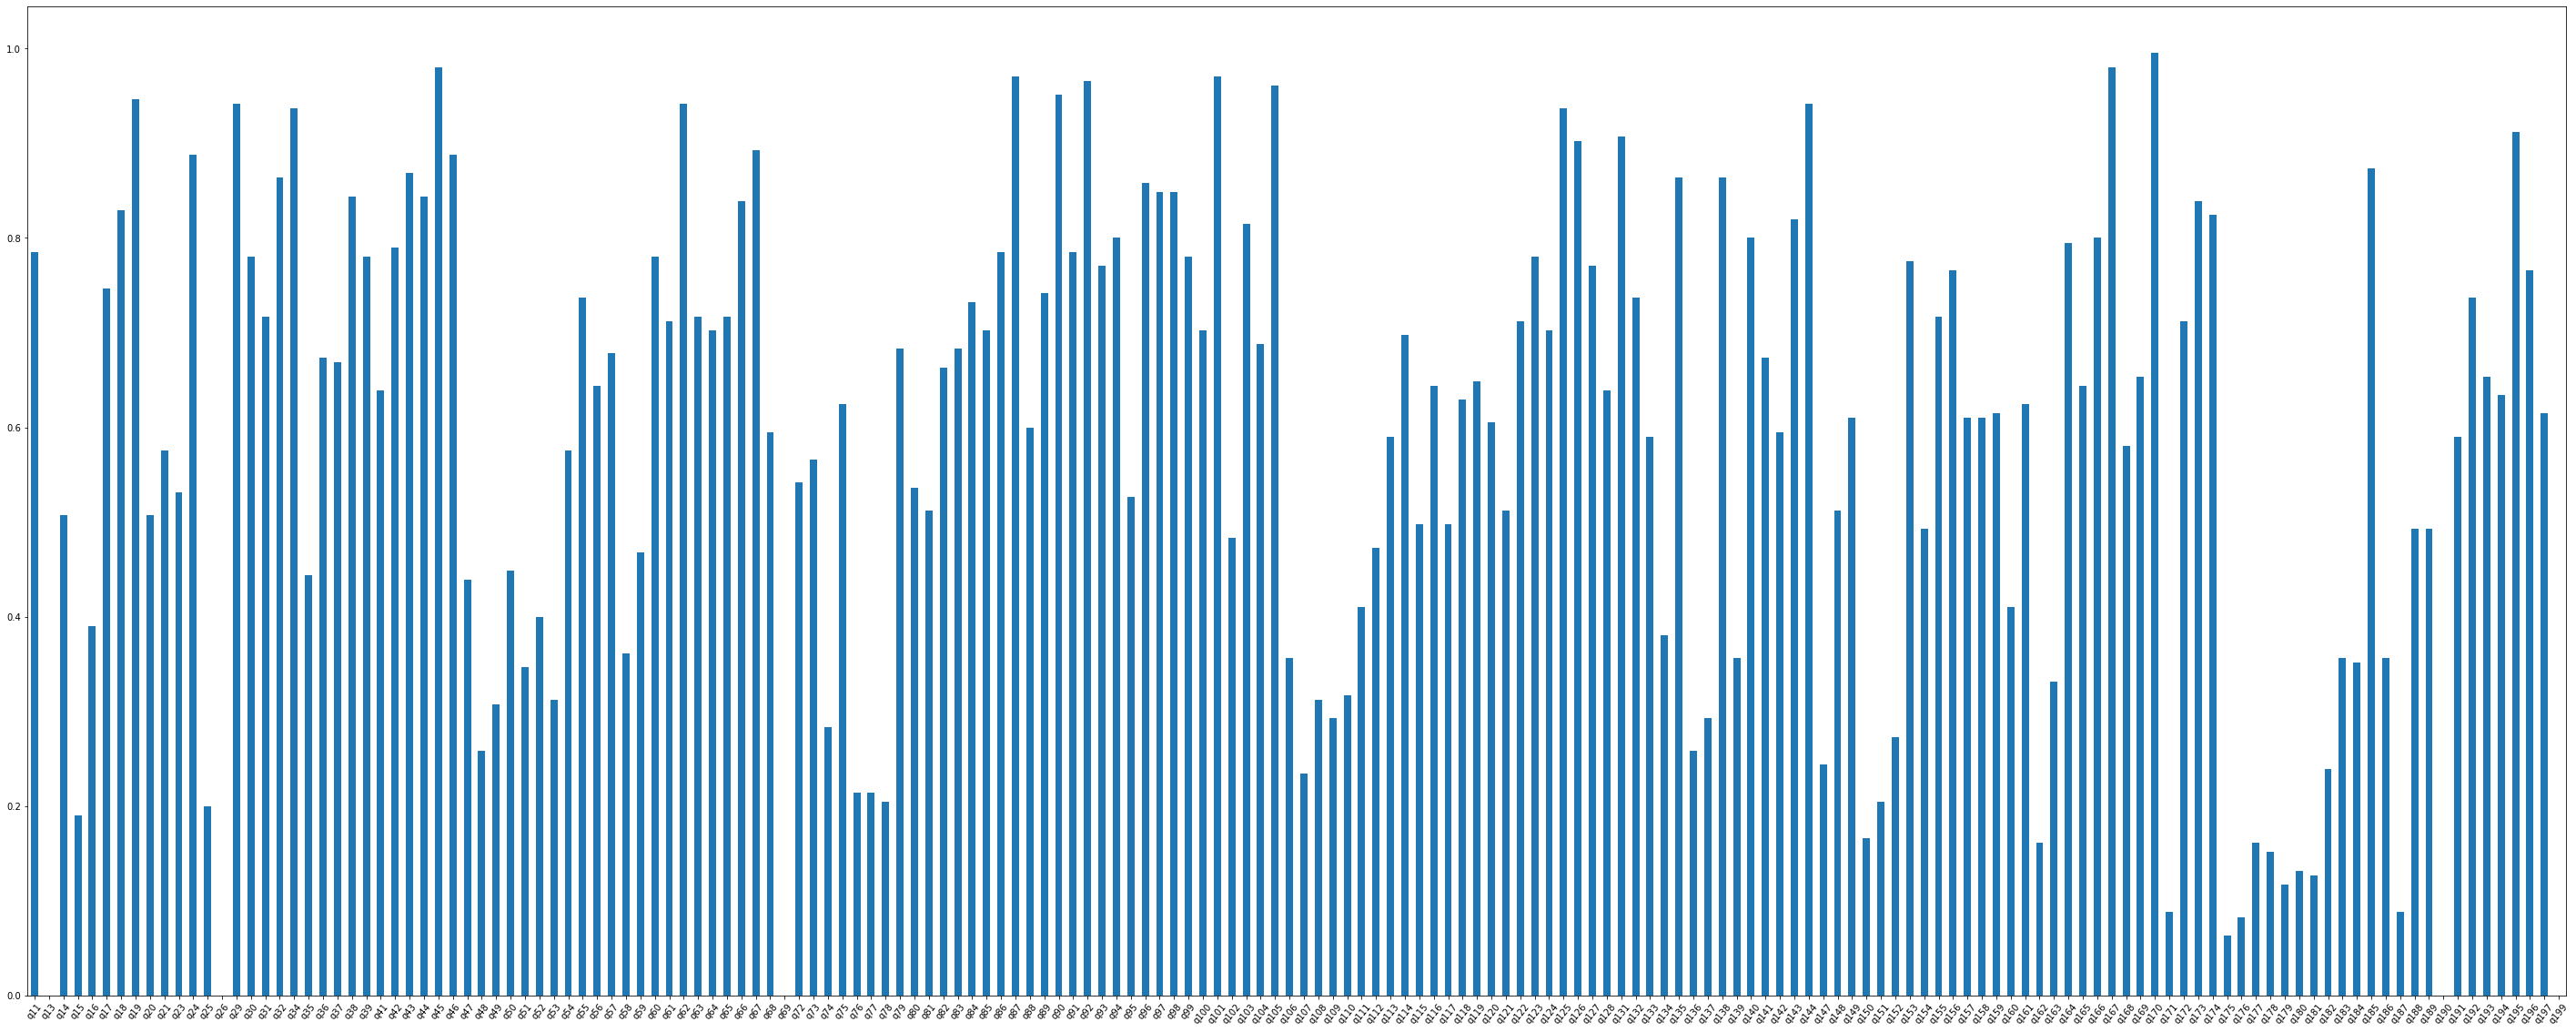

In [7]:
# visualize missingness

question_data_unlabeled = question_data.drop(columns=['id', 'nid'])
q_nullseries = question_data_unlabeled.isna().sum() / question_data_unlabeled.shape[0] # calculate % NaN per column
ax = q_nullseries.plot.bar(x='question', y='% missing', rot=50, figsize=(50,20)) # plot question vs. % missing

In [8]:
# collapse rows with the same ID by picking the one with the least missingness

for i in question_data.id.unique(): # for each unique id...
    temp = question_data[question_data.id == i].copy() # extract rows with corresponding id
    if temp.shape[0] > 1: # if there is more than one entry...
        idx = temp.isna().sum(axis=1).idxmin() # get the id of the row with min missing
        idxs = list(temp.index.values)
        idxs.remove(idx)
        question_data.drop(index=idxs, inplace=True)
        
question_data.shape

(123, 178)

In [9]:
# drop columns with a higher % missing than our threshold

cols_to_drop = []
    
for ind,val in q_nullseries.iteritems():
    if val > missingness_threshold:
        cols_to_drop.append(ind)

question_data.drop(columns=cols_to_drop, inplace=True)
question_data.shape

(123, 161)

In [10]:
#outcomes = pd.read_stata('./data/full_cohort_with_clinical_outcomes.dta') # older version of outcome data
outcomes = pd.read_stata('./data/test.dta') # read outcome data
print(outcomes.shape)
outcomes.head()

(123, 372)


,ptid,center_ptid,var3,trr_id_code,sex,age,race,primarylanguage,insurance,drinksperday,yrsheavydrink,marital,psych,psychmed,smoke1illicit2,smoker,thc,rehab,famhx,job,legalhx,var22,var23,lastdrink,initial_hospdate,center_hospdate,listdate,ltdate,dischargedate,lastcontact,death,jaundice,jaundicedate,heavydrink,contributingcause,var36,therapy,therapyduration,steroid_whynot,lille_steroid,lille_nosteroid,osh_lab_date,sodium_osh,inr_osh,bili_osh,cr_osh,rrt_osh,meld_osh,maddrey_osh,var51,hosp_lab_date,sodium_hosp,inr_hosp,pt_hosp,pt_control,bili_hosp,cr_hosp,rrt_hosp,meld_hosp,maddrey_hosp,wbc,ast,alt,hcv,hbv,albumin,bun_hosp,map_hosp,vasopressor_hosp,pao2ratio_hosp,spo2ratio_hosp,list_lab_date,na_list,inr_list,bili_list,cr_list,rrt_list,meld_list,var80,lt_lab_date,na_lt,inr_lt,bili_lt,cr_lt,rrt_lt,meld_lt,pvt,albumin_lt,bun_lt,map_lt,vasopressor_lt,pao2ratio_lt,spo2_ratio,bmi,var96,vent,gib,ascites,encephalopathy,var101,var102,sepsis,sepsis_type,sepsis_pathogen,sepsis_site,pancreatitis,gib_ah,var109,inf,var111,vascular,biliary,rejection,var115,alc_postlt,alc_diag,binge_alc,freq_alc,stilldrinking,alc_postlt_date,othercomplications,var123,biopsy_recurrent,graftfailure,chronicrejection,prelt_biopsy,var128,var129,var130,var131,var132,var133,center,event,otherid,race_txt,primarylanguage_txt,psych_txt,psychmed_txt,illicit_txt,death_txt,contributingcause_txt,steroid,pentoxifylline,nac,steroid_days,pentoxifylline_days,nac_days,steroid_whynot_txt,vasopressor_hosp_txt,vasopressor_lt_txt,sepsis_date,sepsis_txt,pancreatitis_date,gib_ah_date,gib_ah_txt,inf1_type,inf1_date,inf1_pathogen,inf1_site,inf1_txt,inf2_type,inf2_date,inf2_pathogen,inf2_site,inf2_txt,vascular_date,vascular_txt,biliary_date,biliary_txt,rejection_date,rejection_txt,alc_diagtxt,biopsy_recurrent_date,prelt_biopsy_txt,graftfailure_txt,chronicrejection_txt,var48,var49,lt_date_update,hospdays,postlt_rrt,lost,fu_date_update,death_update,cod_txt,cod_alcohol,death_date_update,postlt_ah,lost_compliance,lost_transition,lost_txt,hospdeath,lastdrink_destring,initial_hospdate_destring,center_hospdate_destring,listdate_destring,ltdate_destring,dischargedate_destring,lastcontact_destring,osh_lab_date_destring,hosp_lab_date_destring,list_lab_date_destring,lt_lab_date_destring,alc_postlt_date_destring,rejection_date_destring,fu_time,fu_time_yrs,death_time,death_time_yrs,abstime,abstime_yrs,hosptime,alc_postlt_interval,alc_postlt_interval_yrs,rejection_time,rejection_time_yrs,caucasian,private,medicaid,medicare,tendrinksperday,fifteenyrsheavydrink,illicit,anyrehab,multiplerehab,anylegalhx,multiplelegalhx,anymarital,anyfamhx,overtencephalopathy,fu_sincelastdrink,sustained_alc,slip,harmfuldrink,ordinaldrink,event_date,event_type,event_hosp,event_hospdate,event_drinksperday,event_drinkingdaysperweek,event_meld,event_ascites,event_overtencephalopathy,event_varicealbleeding,event_jaundice,event_sobriety,event_relapse,event_niaaa_jaundice,event_jaundicedate,event_niaaa_heavy,event_niaaa_contributing,event_niaaa_ast,event_niaaa_ratio,event_biopsy,var24,var25,event_hosp1_date,event_hosp1_reason,event_hosp2_date,event_hosp2_reason,event_hosp3_date,event_hosp3_reason,event_hosp4_date,event_hosp4_reason,event_hosp5_date,event_hosp5_reason,var38,var39,event_withdrawal,event_withdrawal_date,event_pancreatitis,event_pancreatitis_date,event_seizure,event_seizure_date,var46,event_aa,event_aa_date,event_outpatientrehab,event_outpatientrehab_date,event_inpatientrehab,event_inpatientrehab_date,event_med_date,var54,var55,var56,event_factor_txt,event_factor_young,event_factor_children,event_factor_social,event_factor_advocate,event_factor_other,var63,event_contributing_txt,event_biopsy_txt,event_type_txt,var37,var43,var52,var73,var81,var122,var127,explant_txt,nid,id,psychiatrist,counselor,socialworker,narrcount,q2,q25,q26,q27,q28,q29,q30,q31,q34,q99,q123,q124,q125,q126,q127,q144,q146,writer_com,language_com,behavior_com,hpi_com,consistency_com,medhis_com,adherence_com,mental_com,alcohol_com,insight_com,education_

In [11]:
outcomes = outcomes[[outcome, 'center', 'ptid', 'hospdeath']] # extract outcome, location, ID, and death data
outcomes.head()

,harmfuldrink,center,ptid,hospdeath
0,0.0,1,1.0,0.0
1,0.0,1,2.0,0.0
2,0.0,1,3.0,0.0
3,1.0,1,4.0,0.0
4,0.0,1,5.0,0.0


In [12]:
combined = outcomes.merge(question_data, left_on='ptid', right_on='id', how='left') # merge with question data
print(combined.shape)
combined.head()

(123, 165)


,harmfuldrink,center,ptid,hospdeath,q11,q13,q14,q15,q16,q17,q18,q20,q21,q23,q24,q25,q26,q30,q31,q32,q35,q36,q37,q38,q39,q41,q42,q43,q44,q46,q47,q48,q49,q50,q51,q52,q53,q54,q55,q56,q57,q58,q59,q60,q61,q63,q64,q65,q66,q67,q68,q69,q72,q73,q74,q75,q76,q77,q78,q79,q80,q81,q82,q83,q84,q85,q86,q88,q89,q91,q93,q94,q95,q96,q97,q98,q99,q100,q102,q103,q104,q106,q107,q108,q109,q110,q111,q112,q113,q114,q115,q116,q117,q118,q119,q120,q121,q122,q123,q124,q127,q128,q132,q133,q134,q135,q136,q137,q138,q139,q140,q141,q142,q143,q147,q148,q149,q150,q151,q152,q153,q154,q155,q156,q157,q158,q159,q160,q161,q162,q163,q164,q165,q166,q168,q169,q171,q172,q173,q174,q175,q176,q177,q178,q179,q180,q181,q182,q183,q184,q185,q186,q187,q188,q189,q190,q191,q192,q193,q194,q196,q197,q199,id,nid
0,0.0,1,1.0,0.0,NaN,1,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0,NaN,NaN,NaN,0.0,NaN,3.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,36.0,8.0,8.0,0.0,0.0,1.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0,NaN,0.0,0.0,0.0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,1.0,NaN,NaN,1.0,NaN,0.0,NaN,NaN,4.0,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,0.0,1.0,NaN,NaN,NaN,NaN,1.0,1.0,NaN,NaN,NaN,1.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,1.0,NaN,NaN,1.0,NaN,NaN,1,1.0,NaN,0.0,NaN,NaN,2.0,0,1,47
1,0.0,1,2.0,0.0,NaN,2,NaN,0.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,1.0,NaN,1.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0,NaN,60.0,NaN,2.0,NaN,NaN,NaN,NaN,30.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,1.0,1.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,2.0,2.0,NaN,1.0,NaN,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,NaN,NaN,NaN,NaN,1.0,1.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,1.0,1.0,3,1.0,NaN,NaN,1.0,NaN,NaN,0,2,48
2,0.0,1,3.0,0.0,NaN,1,NaN,0.0,2.0,NaN,NaN,0.0,0.0,NaN,NaN,0.0,0,NaN,0.0,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,7.0,8.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,NaN,1.0,1.0,NaN,1.0,NaN,NaN,2.0,NaN,5.0,NaN,NaN,1.0,1.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,3.0,1.0,1.0,1.0,NaN,0.0,0.0,0.0,1.0,1.0,NaN,NaN,NaN,1.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,1.0,NaN,NaN,1.0,NaN,NaN,1,1.0,NaN,0.0,NaN,NaN,NaN,0,3,49
3,1.0,1,4.0,0.0,NaN,2,1.0,1.0,2.0,NaN,NaN,0.0,0.0,1.0,NaN,0.0,0,NaN,NaN,NaN,0.0,0.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,NaN,1.0,NaN,1.0,0.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,1.0,1.0,NaN,1.0,NaN,NaN,2.0,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,0.0,0.0,NaN,0.0,NaN,NaN,1.0,1.0,NaN,NaN,NaN,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,NaN,NaN,1.0,0.0,NaN,1.0,2,1.0,NaN,NaN,1.0,NaN,NaN,0,4,81
4,0.0,1,5.0,0.0,NaN,2,1.0,0.0,2.0,NaN,NaN,0.0,NaN,NaN,NaN,0.0,0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,1.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,18.0,1.0,1.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,12.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,1.0,1.0,1.0,1.0,2.0,2.0,NaN,NaN,5.0,NaN,0.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,0.0,NaN,0.0,NaN,NaN,1.0,1.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,1.0,4,1.0,NaN,0.0,NaN,NaN,2.0,0,

In [13]:
combined = combined[combined.hospdeath != 1] # remove patients who died in the hospital
combined.drop(columns=['hospdeath'], inplace=True)
combined.shape

(116, 164)

In [14]:
combined[outcome].value_counts() / combined.shape[0] # outcome distribution

0.0    0.706897
1.0    0.293103
Name: harmfuldrink, dtype: float64

In [15]:
combined[outcome].value_counts()

0.0    82
1.0    34
Name: harmfuldrink, dtype: int64

In [16]:
combined[outcome].isna().sum() # verify no missing outcome variables

0

In [17]:
# combined[outcome].fillna(0, inplace=True) # replace missing outcome with 0 meaning no harmful drinking
combined.drop(inplace=True, columns=['id', 'ptid', 'nid']) # remove merging variables
print(combined.shape)
combined.head()

(116, 161)


,harmfuldrink,center,q11,q13,q14,q15,q16,q17,q18,q20,q21,q23,q24,q25,q26,q30,q31,q32,q35,q36,q37,q38,q39,q41,q42,q43,q44,q46,q47,q48,q49,q50,q51,q52,q53,q54,q55,q56,q57,q58,q59,q60,q61,q63,q64,q65,q66,q67,q68,q69,q72,q73,q74,q75,q76,q77,q78,q79,q80,q81,q82,q83,q84,q85,q86,q88,q89,q91,q93,q94,q95,q96,q97,q98,q99,q100,q102,q103,q104,q106,q107,q108,q109,q110,q111,q112,q113,q114,q115,q116,q117,q118,q119,q120,q121,q122,q123,q124,q127,q128,q132,q133,q134,q135,q136,q137,q138,q139,q140,q141,q142,q143,q147,q148,q149,q150,q151,q152,q153,q154,q155,q156,q157,q158,q159,q160,q161,q162,q163,q164,q165,q166,q168,q169,q171,q172,q173,q174,q175,q176,q177,q178,q179,q180,q181,q182,q183,q184,q185,q186,q187,q188,q189,q190,q191,q192,q193,q194,q196,q197,q199
0,0.0,1,NaN,1,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0,NaN,NaN,NaN,0.0,NaN,3.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,36.0,8.0,8.0,0.0,0.0,1.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0,NaN,0.0,0.0,0.0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,1.0,NaN,NaN,1.0,NaN,0.0,NaN,NaN,4.0,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,0.0,1.0,NaN,NaN,NaN,NaN,1.0,1.0,NaN,NaN,NaN,1.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,1.0,NaN,NaN,1.0,NaN,NaN,1,1.0,NaN,0.0,NaN,NaN,2.0,0
1,0.0,1,NaN,2,NaN,0.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,1.0,NaN,1.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0,NaN,60.0,NaN,2.0,NaN,NaN,NaN,NaN,30.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,1.0,1.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,2.0,2.0,NaN,1.0,NaN,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,NaN,NaN,NaN,NaN,1.0,1.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,1.0,1.0,3,1.0,NaN,NaN,1.0,NaN,NaN,0
2,0.0,1,NaN,1,NaN,0.0,2.0,NaN,NaN,0.0,0.0,NaN,NaN,0.0,0,NaN,0.0,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,7.0,8.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,NaN,1.0,1.0,NaN,1.0,NaN,NaN,2.0,NaN,5.0,NaN,NaN,1.0,1.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,3.0,1.0,1.0,1.0,NaN,0.0,0.0,0.0,1.0,1.0,NaN,NaN,NaN,1.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,1.0,NaN,NaN,1.0,NaN,NaN,1,1.0,NaN,0.0,NaN,NaN,NaN,0
3,1.0,1,NaN,2,1.0,1.0,2.0,NaN,NaN,0.0,0.0,1.0,NaN,0.0,0,NaN,NaN,NaN,0.0,0.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,NaN,1.0,NaN,1.0,0.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,1.0,1.0,NaN,1.0,NaN,NaN,2.0,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,0.0,0.0,NaN,0.0,NaN,NaN,1.0,1.0,NaN,NaN,NaN,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,NaN,NaN,1.0,0.0,NaN,1.0,2,1.0,NaN,NaN,1.0,NaN,NaN,0
4,0.0,1,NaN,2,1.0,0.0,2.0,NaN,NaN,0.0,NaN,NaN,NaN,0.0,0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,1.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,18.0,1.0,1.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,12.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,1.0,1.0,1.0,1.0,2.0,2.0,NaN,NaN,5.0,NaN,0.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,0.0,NaN,0.0,NaN,NaN,1.0,1.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,1.0,4,1.0,NaN,0.0,NaN,NaN,2.0,0


In [18]:
combined.to_csv('./data/data_final.csv') # checkpoint data

In [19]:
combined['center'].value_counts()

5     36
9     15
8     12
1     11
11    10
7     10
6      9
3      7
4      3
2      3
Name: center, dtype: int64

In [20]:
val = combined[combined.center == validation_center] # reserve one center for validation
val_X = val.drop(columns=[outcome]) # extract predictors
val_y = val[outcome] # extract outcome
print(val_X.shape, val_y.shape)

combined = combined[combined.center != validation_center] # remove center from rest of dataset

(12, 160) (12,)


In [21]:
val_y.value_counts()

0.0    6
1.0    6
Name: harmfuldrink, dtype: int64

In [22]:
X = combined.drop(columns=[outcome]) # extract predictors
y = combined[outcome] # extract outcome
print(X.shape, y.shape)

(104, 160) (104,)


In [23]:
y.value_counts()

0.0    76
1.0    28
Name: harmfuldrink, dtype: int64

In [24]:
X.isna().sum().sum()

8280

In [25]:
# impute missing data

if imputation_strategy == '-1':
    X.fillna(-1, inplace=True) # replace NaN with -1 to signify ommitted question
elif imputation_strategy == 'mode':
    for col in X.columns:
        X[col].fillna(X[col].mode()[0], inplace=True)

In [26]:
X.isna().sum().sum()

8280

## Modelling



Optimal number of features: 12


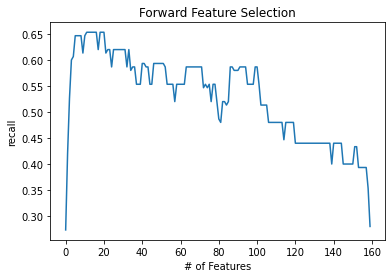

In [27]:
def forward_feature_selection(model, X, y):
    features = list(X.columns)
    selected_features = []
    scores = []
    
    for i in tqdm(range(X.shape[1])):
        best_score = 0
        next_feat = ''
        for feat in features:
            selected_features.append(feat)
            temp_X = X[selected_features]
            temp_scores = cross_validate(clone(model), temp_X, y, cv=5, scoring=['recall'])
            temp_score = temp_scores['test_recall'].mean()
            if temp_score >= best_score:
                best_score = temp_score
                next_feat = feat
            selected_features.pop()
        #print('Added Feature:', next_feat)
        selected_features.append(next_feat)
        features.remove(next_feat)
        scores.append(best_score)
        
    #print('Ordering of Features:', selected_features)
    
    plt.title('Forward Feature Selection')
    plt.xlabel('# of Features')
    plt.ylabel('recall')
    plt.plot(list(range(X.shape[1])), scores)
    return scores, selected_features

if include_feature_selection:
    scores, selected_features = forward_feature_selection(model, X, y)
    optimal_n_features = scores.index(max(scores)) + 1
    print('\nOptimal number of features:', optimal_n_features)
    optimal_features = selected_features[:optimal_n_features]
    X = X[optimal_features]
    val_X = val_X[optimal_features]

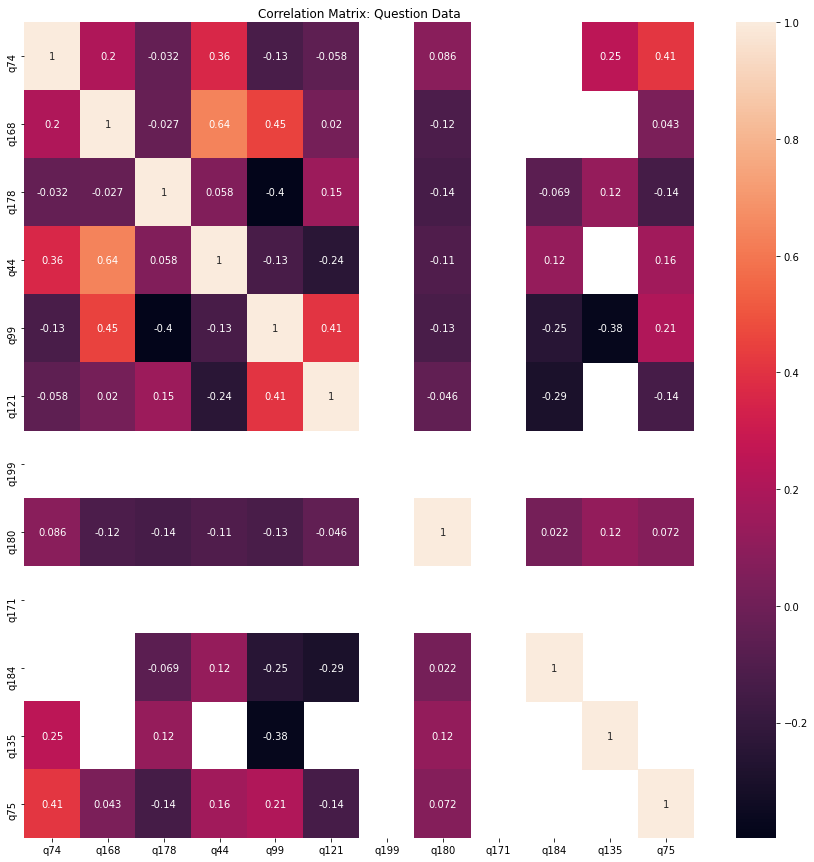

In [40]:
# get correlation matrix of selected features for qualitative analysis

corrMatrix = X.corr()
sn.heatmap(corrMatrix, annot=True)
plt.rcParams['figure.figsize'] = 15, 15
plt.title('Correlation Matrix: Question Data')
plt.show()

In [29]:
# get value counts for our selected features for qualitative analysis

nullseries = X.isna().sum() / X.shape[0] # calculate % NaN per column of selected features
for feat in X.columns:
    print('--' + feat + '--')
    try:
        print('NaN ', nullseries[feat])
    except KeyError: # center variable not in q_nullseries, default to 0 missing values
        print('NaN  0')
    print(X[feat].value_counts() / X.shape[0]) 

--q74--
NaN  0.16346153846153846
11.00    0.086538
17.00    0.076923
12.00    0.057692
8.00     0.048077
10.00    0.048077
6.00     0.048077
5.00     0.048077
7.00     0.028846
22.00    0.028846
4.00     0.028846
22.50    0.019231
16.00    0.019231
30.00    0.019231
11.25    0.019231
9.00     0.019231
13.00    0.019231
5.50     0.019231
33.00    0.019231
12.50    0.019231
19.50    0.019231
20.00    0.019231
15.00    0.009615
34.00    0.009615
24.00    0.009615
21.00    0.009615
36.00    0.009615
2.50     0.009615
6.80     0.009615
43.00    0.009615
28.00    0.009615
3.00     0.009615
6.50     0.009615
15.60    0.009615
6.60     0.009615
Name: q74, dtype: float64
--q168--
NaN  0.5769230769230769
0.0    0.336538
1.0    0.086538
Name: q168, dtype: float64
--q178--
NaN  0.08653846153846154
0.0    0.673077
1.0    0.240385
Name: q178, dtype: float64
--q44--
NaN  0.7692307692307693
0.0    0.182692
1.0    0.048077
Name: q44, dtype: float64
--q99--
NaN  0.6730769230769231
1.0    0.173077
0.0   

In [30]:
# evaluate performance of model (confidence intervals)

scores = cross_validate(clone(model), X, y, cv=5, scoring=['accuracy', 'precision', 'recall', 'roc_auc'], return_estimator=True)

confidence_level = 0.95
print('Accuracy:', round(scores['test_accuracy'].mean(), 4), "+/-", round(confidence_level * scores['test_accuracy'].std() / sqrt(X.shape[0]), 4))
print('Precision/PPV:', round(scores['test_precision'].mean(), 4), "+/-", round(confidence_level * scores['test_precision'].std() / sqrt(X.shape[0]), 4))
print('Recall:', round(scores['test_recall'].mean(), 4), "+/-", round(confidence_level * scores['test_recall'].std() / sqrt(X.shape[0]), 4))
print('AUC:', round(scores['test_roc_auc'].mean(), 4), "+/-", round(confidence_level * scores['test_roc_auc'].std() / sqrt(X.shape[0]), 4))

Accuracy: 0.8267 +/- 0.0073
Precision/PPV: 0.6886 +/- 0.0173
Recall: 0.6533 +/- 0.0233
AUC: 0.7134 +/- 0.014


In [31]:
# have model predict on validation center to gague performance

recall_scores = list(scores['test_recall'])
top_model = scores['estimator'][recall_scores.index(max(recall_scores))] # select model with best recall score
val_y_pred = top_model.predict(val_X)

tn, fp, fn, tp = metrics.confusion_matrix(val_y, val_y_pred).ravel()
(tn, fp, fn, tp)

(6, 0, 5, 1)

In [39]:
try:
    print('Accuracy:', round(metrics.accuracy_score(val_y, val_y_pred), 4))
    print('Precision/PPV:', round(metrics.precision_score(val_y, val_y_pred), 4))
    print('NPV:', round(tn / (tn + fn), 4))
    print('Recall', round(metrics.recall_score(val_y, val_y_pred), 4))
    print('AUC:', round(metrics.roc_auc_score(val_y, val_y_pred), 4))
except ValueError as e:
    print(e)

Accuracy: 0.5833
Precision/PPV: 1.0
NPV: 0.5455
Recall 0.1667
AUC: 0.5833


## Post-Processing

In [33]:
# collect feature importance values

try:
    y = top_model.feature_importances_ # for Random Forest & XGBoost
except AttributeError:
    y = top_model.coef_[0] # for logistic regression

d = {'q': X.columns, 'feat_imp': y} # create feature importance dataframe
feat_imp = pd.DataFrame(data=d).sort_values(by='feat_imp', ascending=False)

In [34]:
# merge % missing with feature importances
feat_imp = feat_imp.merge(nullseries.rename('% NaN').to_frame(),left_index=False,left_on='q',right_index=True)

In [35]:
# convert questions from "q{XXX}" format to full English question

def question_decoder(question_code):
    if '_split' in question_code:
        question_code = question_code.replace('_split','')
    question_code = question_code.upper()
    
    df = pd.read_excel('./data/Psychosocial data dictionary.xlsx', index_col=0)
    questions = df['QUESTIONS']
    try:
        return questions[question_code]
    except KeyError:
        return None

feat_imp['q_decoded'] = feat_imp['q'].apply(lambda x: question_decoder(x))
feat_imp

,q,feat_imp,% NaN,q_decoded
3,q44,0.169936,0.769231,"Prior to this admission, has the patient had problems with adherence to medical appointments (i.e., missed appointments and/or lost to follow-up)?"
9,q184,0.151339,0.336538,What is the current health status of the patient's spouse or significant other? (Enter 99 if not applicable.)
2,q178,0.148446,0.086538,Are there any pediatric children or grandchildren (<18 years old) who live with the patient?
5,q121,0.114214,0.442308,Has the patient started a formal alcohol treatment program prior to undergoing this pre-transplant evaluation?
0,q74,0.111685,0.163462,"How many standard drink equivalents on average per day (during time period of heaviest drinking)?\nCALCULATOR:\n Beer or cooler: 12 oz = 1, 16 oz = 1.3, 22 oz = 2, 40 oz = 3.3\n Malt liquor: 8-9 oz = 1, 12 oz = 1.5, 16 oz = 2, 22 oz = 2.5, 40 oz = 4.5\n Table wine: 5 oz = 1, a 750 mL (25 oz) bottle = 5\n Hard liquor (80-proof spirits): 1.5 oz = 1, mixed drink = 1-3, pint (16 oz) = 11, fifth (25 oz) = 17, 1.75L (59 oz) = 39"
4,q99,0.110450,0.673077,"Prior to this episode, had the patient ever been counseled on the need for 100% alcohol abstinence by a physician?"
1,q168,0.099869,0.576923,Is the patient currently on disability?
11,q75,0.094062,0.557692,"For how many years was the patient drinking heavily (>7 standard drinks/week for woman, >14 standard drinks/week for man)?"
6,q199,0.000000,0.000000,"Does the writer describe special circumstances of increased perceived social worth of the patient (e.g., 9/11 responder, philanthropist)?"
7,q180,0.000000,0.057692,Does the patient currently live with any sibling(s)?


## Don't be dumb...

In [36]:
# triggers a ctrl-s so that conversion to html will work properly

def save_notebook(file_path):
    start_md5 = hashlib.md5(open(file_path,'rb').read()).hexdigest()
    display(Javascript('IPython.notebook.save_checkpoint();'))
    current_md5 = start_md5
    
    while start_md5 == current_md5:
        time.sleep(1)
        current_md5 = hashlib.md5(open(file_path,'rb').read()).hexdigest()
        
save_notebook('mvp.ipynb')

<IPython.core.display.Javascript object>

In [42]:
now = datetime.now()
current_time = now.strftime("(%H:%M:%S)")
current_date = now.date().strftime("%b-%d")

filename = current_date + current_time + ".html"
print("saving results to " + filename)
os.system("ipython nbconvert --to html mvp.ipynb")
os.rename('mvp.html', "./raw_results/" + filename)

saving results to Apr-19(21:23:30).html
